In [119]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import new_alg_v2 as na

In [120]:
# defining the network
class Net(nn.Module):
  def __init__(self, n):
    super().__init__()
    # an affine operation: y = Wx + b
    self.n = n 
    seed = 6
    torch.manual_seed(seed) 
    self.fc1 = nn.Linear(n, n, bias=False)
    self.fc1.weight.data.normal_(0, 1/np.sqrt(n))
    torch.manual_seed(seed)
    self.fc2 = nn.Linear(n, 1, bias=False)
    self.fc2.weight.data.normal_(0, 1/np.sqrt(n))

  def forward(self, x):
    x = self.fc1(x)
    z_hat = self.fc2(x)
    return z_hat

In [121]:
def avg_k_test(net, x_input, n, k, steps, alpha):
  lossVector = []
  #x_input = torch.randn(n)
  z_target = torch.tensor([1.])
  lossVector = []
  lr = alpha*(float(n)**(-k))
  loss_f = nn.MSELoss()
  #optimizer:
  optimizerSGD = optim.SGD(net.parameters(), lr)
  optimizer = na.new_alg(net.parameters(), lr)
  
  for i in range(steps):
    optimizerSGD.zero_grad()
    z_hat = net.forward(x_input)
    loss = loss_f(z_hat, z_target)
    lossVector.append(float(loss))
    loss.backward()
    optimizer.step()
    
  return lossVector

In [122]:
n_sizes = np.array([500,2000])
#n_sizes = np.array([100])
n_n = len(n_sizes)
K = np.array([0,0.5,0.7,1,1.5,2])
#K = np.array([0,0.001,0.002,0.003,0.004,0.005])
#K = np.array([0,0.5,1,1.5,2])
n_k = len(K)
n_steps = 80
x = np.arange(n_steps)
losses = np.zeros((n_k, n_n, n_steps))

lr_100 = 0.5e-3
#lr_100 = 0.5

from copy import deepcopy

for i_n, n in enumerate(n_sizes):
  net = Net(n)
  sd_init = deepcopy(net.state_dict())
  x_input = torch.randn(n)
  for i_k, k in enumerate(K):
    net.load_state_dict(sd_init)
    alpha = lr_100 * 100**k
    loss_i = avg_k_test(net, x_input, n, k, n_steps, alpha)
    losses[i_k, i_n] = loss_i

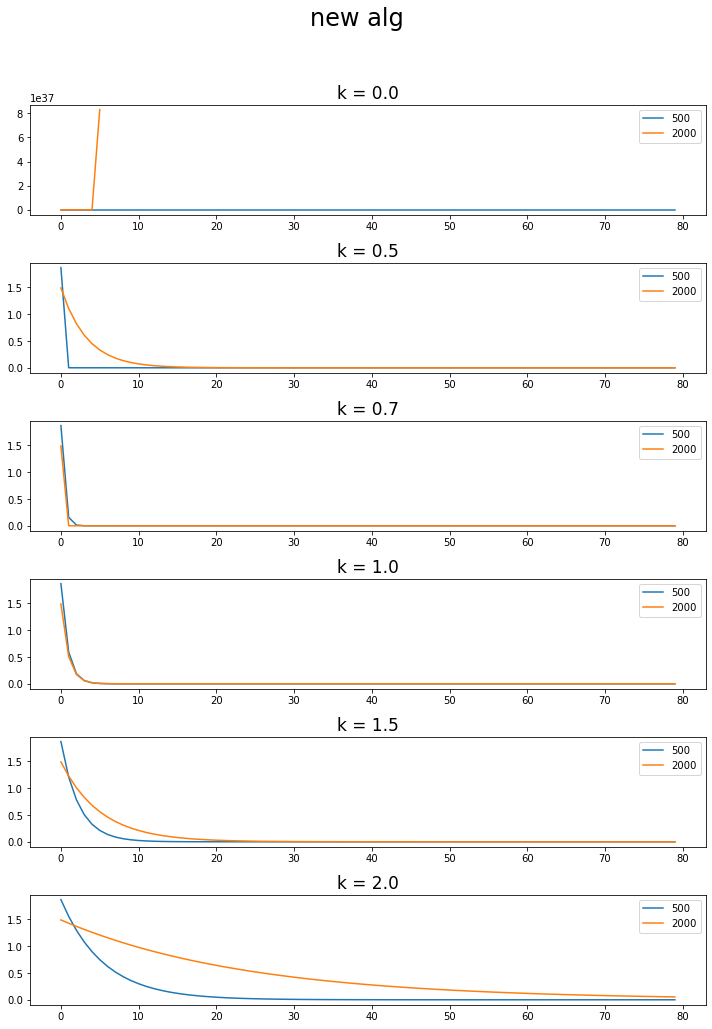

In [123]:
# testing different k's for SGD

fig = plt.figure(figsize=(10, 15))
fig.suptitle('new alg', fontsize = 24)
axes = fig.subplots(n_k, 1)
for i_k, k in enumerate(K):
  ax1 = axes[i_k]
  STR = "k = " + str(k)
  for i_n, n in enumerate(n_sizes):
    loss_i = losses[i_k, i_n]
    ax1.plot(x, loss_i, label = n)
  #ax1.set_yscale("log")
  ax1.set_title(STR, fontsize=17)
  ax1.legend()

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# for k=1:

In [126]:
from tqdm import tqdm

In [124]:
def new_alg_loss(n):
  z_target = torch.ones(1)
  torch.manual_seed(12)
  x_input = torch.randn(n)

  loss_w1=0.0
  loss_w2=0.0 

  net = Net(n)
  w1_init = net.fc1.weight.clone()
  w2_init = net.fc2.weight.clone()
  
  loss_f = nn.MSELoss()
  
  steps = 200
  alpha = 0.5e-2
  lr = alpha*(float(n)**(-1))
  
  optimizerSGD = optim.SGD(net.parameters(), lr)
  optimizer = na.new_alg(net.parameters(), lr)
  
  loss_n = []

  # training
  for i in range(steps):
    optimizerSGD.zero_grad()
    z_hat = net.forward(x_input)
    loss = loss_f(z_hat, z_target)
    loss.backward()
    optimizer.step()
    loss_n.append(float(loss))
  
  w1_final_SGD = net.fc1.weight.clone()
  #w2_final_SGD = net.fc2.weight.clone()

  
  # w1-init, w2-final
  with torch.no_grad():
    net.fc1.weight[:] = w1_init
    #second layer is already w2_final
    z_hat = net.forward(x_input)
    loss_w1 += loss_f(z_hat, z_target)
                
  # w1-final, w2-init
  with torch.no_grad():
    net.fc1.weight[:] = w1_final_SGD
    net.fc2.weight[:] = w2_init
    z_hat = net.forward(x_input)
    loss_w2 += loss_f(z_hat, z_target)


  #initializing nn for Adam
  with torch.no_grad():
    net.fc1.weight[:] = w1_init
    net.fc2.weight[:] = w2_init


  return loss_w1, loss_w2, loss_n

In [127]:
l1_loss=[]
l2_loss=[]
final_losses = []
loss_n_trajectory = []

#n_sizes = (100,500,1000,2000,3000,3500,4000,4500,5000)
n_sizes = (100,500,1000,2000,3000,4000,5000)

for n in tqdm(n_sizes):

  loss_L1, loss_L2, loss_n = new_alg_loss(n)
  l1_loss.append(loss_L1)
  l2_loss.append(loss_L2)
  loss_n_trajectory.append(loss_n)


100%|██████████| 7/7 [00:56<00:00,  8.08s/it]


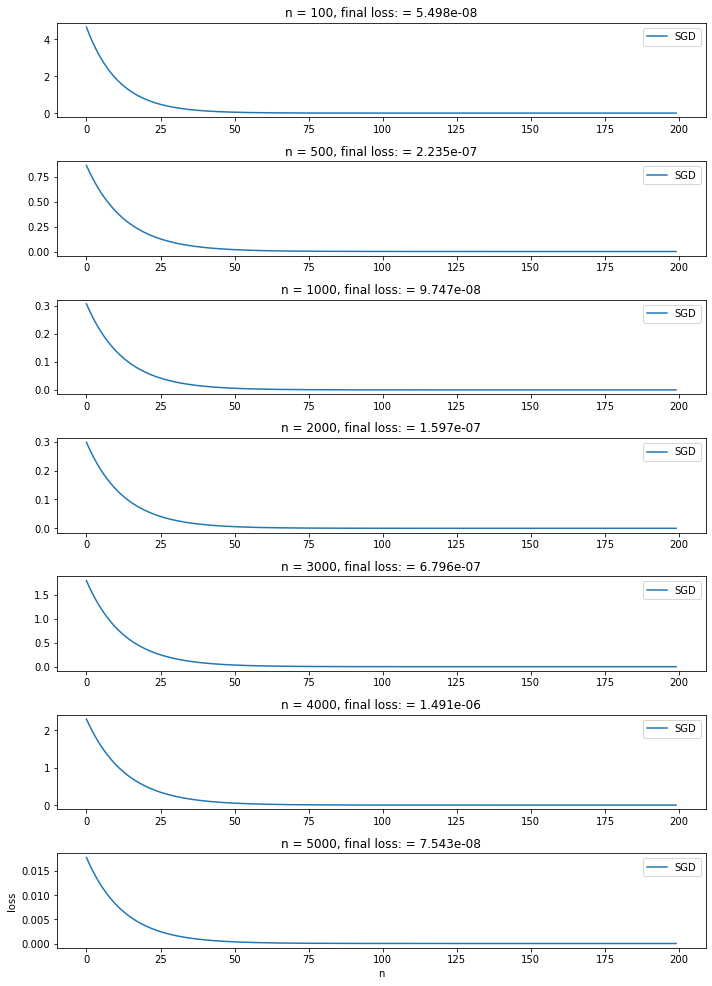

In [132]:
final_losses = []
fig = plt.figure(figsize=(10, 15))
steps = np.arange(0,200,1)
axes = fig.subplots(len(n_sizes), 1)
for i,n in enumerate(n_sizes):
  ax1 = axes[i]
  plt.ylabel('loss')
  plt.xlabel('n')
  loss = loss_n_trajectory[i]
  ax1.plot(steps, loss, label = 'SGD')
  STR = "n = " + str(n) + ", final loss: = " + str(loss[199])[:5] + str(loss[199])[-4:]
  ax1.set_title(STR, fontsize=12)
  ax1.legend()
  final_losses.append(loss[199])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Text(0.5, 0.98, 'Losses vs n')

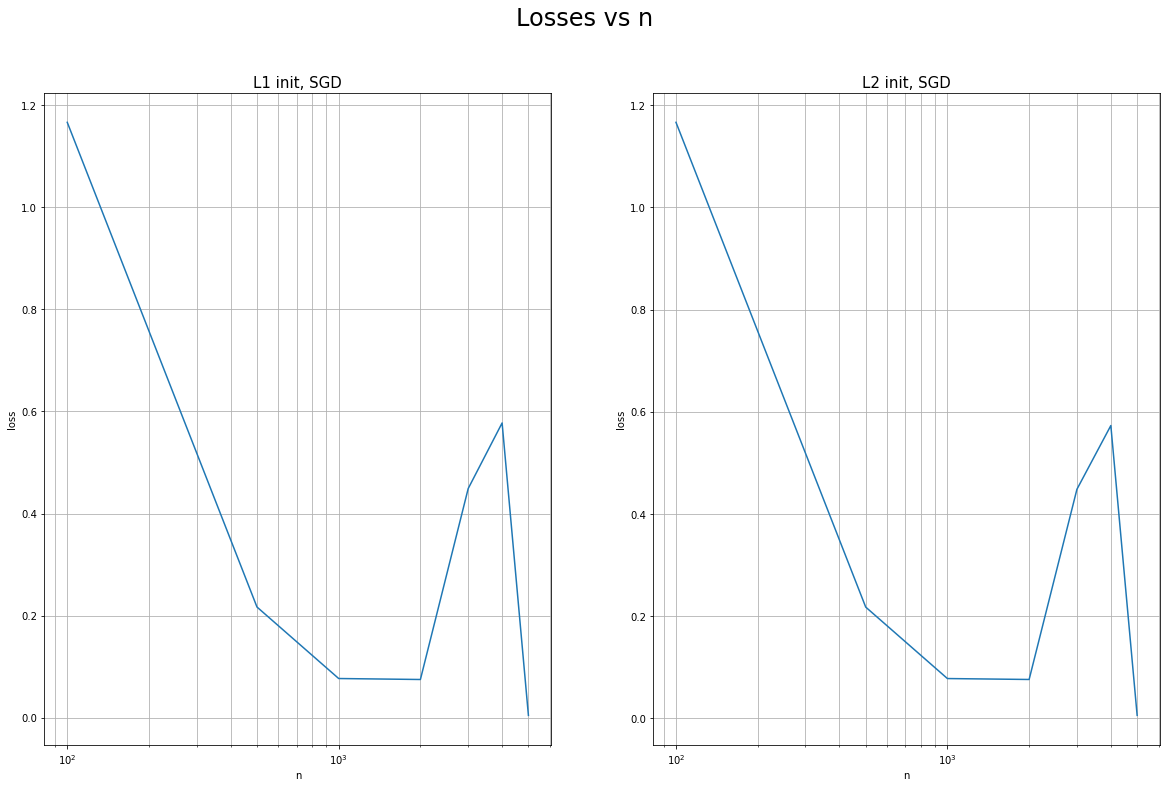

In [134]:
# plotting results

x=np.arange(100, 5000, 200)

fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(121)
ax1.semilogx(n_sizes, l1_loss)
plt.ylabel('loss')
plt.xlabel('n')
ax1.set_title("L1 init, SGD", fontsize=15)
ax1.grid(True, which="both")

ax2 = fig.add_subplot(122)
ax2.semilogx(n_sizes, l2_loss)
plt.ylabel('loss')
plt.xlabel('n')
ax2.set_title("L2 init, SGD", fontsize=15)
ax2.grid(True, which="both")

fig.suptitle("Losses vs n", fontsize=24)



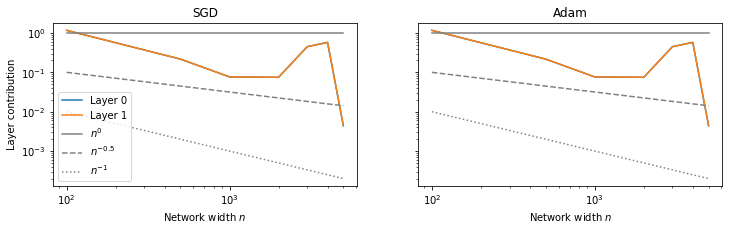

In [136]:
# Plotting results
x = np.array(n_sizes)
ys = np.array([
    [l1_loss, 
    l2_loss,
    ],
    [l1_loss, 
    l2_loss, 
    ],
])
n_opt, n_layers, n_x = ys.shape

n_rows = 1
n_cols = n_opt
fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True,
                         figsize=(12, 3))
for i in range(n_opt):
    ax = axes[i]
    for i_l in range(n_layers):
        ax.plot(x, ys[i, i_l], label="Layer %d" % (i_l))
    
    # Theory?
    
    # Scales
    ax.plot(x, x**0, '-', c='0.5', label=r"$n^0$")
    ax.plot(x, x**-0.5, '--', c='0.5', label=r"$n^{-0.5}$")
    ax.plot(x, x**-1., ':', c='0.5', label=r"$n^{-1}$")
    
    if i == 0:
        ax.set_ylabel('Layer contribution')
        ax.legend(loc=3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Network width $n$')
    title = ["SGD", "Adam"][i]
    ax.set_title(title)

In [141]:
ys

array([[[1.1668394 , 0.21670511, 0.07655604, 0.07464031, 0.44892845,
         0.57753736, 0.0043574 ],
        [1.1668451 , 0.21675657, 0.07670533, 0.07488301, 0.44764015,
         0.57255626, 0.00457811]],

       [[1.1668394 , 0.21670511, 0.07655604, 0.07464031, 0.44892845,
         0.57753736, 0.0043574 ],
        [1.1668451 , 0.21675657, 0.07670533, 0.07488301, 0.44764015,
         0.57255626, 0.00457811]]], dtype=float32)

Text(0.5, 1.0, "['new alg']")

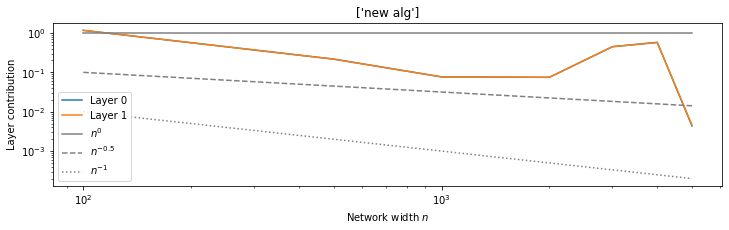

In [146]:
# Plotting results
x = np.array(n_sizes)
ys = np.array([
    [l1_loss, 
    l2_loss,
    ]
])
n_opt, n_layers, n_x = ys.shape

n_rows = 1
n_cols = n_opt
fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True,
                         figsize=(12, 3))

for i_l in range(n_layers):
    axes.plot(x, ys[i, i_l], label="Layer %d" % (i_l))

# Theory?

# Scales
axes.plot(x, x**0, '-', c='0.5', label=r"$n^0$")
axes.plot(x, x**-0.5, '--', c='0.5', label=r"$n^{-0.5}$")
axes.plot(x, x**-1., ':', c='0.5', label=r"$n^{-1}$")

if i == 0:
    axes.set_ylabel('Layer contribution')
    axes.legend(loc=3)
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel('Network width $n$')
title = ["new alg"]
axes.set_title(title)